In [129]:
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter  , ScalarFormatter
import matplotlib.axes as ax
import numpy as np
import math
import statistics as st
import re
import scipy


Client1_instance1 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client1/E52ROC1I1_T64_C2' #_try1_Size1.log'
Client1_instance2 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client1/E52ROC1I2_T64_C2'#_try1_Size1.log'

Client2_instance1 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client2/E52ROC2I1_T64_C2' #_try1_Size1.log'
Client2_instance2 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client2/E52ROC2I2_T64_C2' #_try1_Size1.log'

Client3_instance1 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client3/E52ROC3I1_T64_C2' #_try1_Size1.log'
Client3_instance2 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Client3/E52ROC3I2_T64_C2' #_try1_Size1.log'


# AGGREGATE FOR SINGLE CLIENT

In [130]:
def extract_latencies(file_path):
    latencies=np.zeros(60)
    count=0
    with open(file_path) as file_client:
        #print(file_path)
        file_client=file_client.readlines()
        file_client=file_client[3].split("\r")
        avg = file_client[59].split(",")[4].split()[2]
        length = len(file_client[59].split(",")[4].split()[2])
        avg = avg[0:length-1]
        avg = float(avg)
        for line in file_client:
            if(line!='\n'):
                line=line.split(",")[4]
                #print(line)
                if(line.split()[0]!='-nan'):
                    #print(line.split()[0])
                    latencies[count] = float(line.split()[0])
                else:
                    latencies[count] = avg
    
            count+=1
            if (count==60):
                break
    return latencies


def extract_throughput(file_path, mode):
    with open(file_path) as file_client:
        file_client=file_client.readlines()
        for line in file_client:
            if(len(line.split())>0):
                if(line.split()[0]==mode):
                    #print(line.split()[0])
                    return (float(line.split()[1]))
                

                
                
def extract_weigths(file_path_instance1, file_path_instance2):
    weigths = np.zeros(2)
    throughput = np.zeros(2)
    throughput[0] = extract_throughput(file_path_instance1, 'Totals')
    throughput[1] = extract_throughput(file_path_instance2, 'Totals')
    sum_thr = throughput[0] + throughput[1]
    weigths[0] = throughput[0]/sum_thr
    weigths[1] = throughput[1]/sum_thr
    return weigths






def weighted_latencies(path_instance_c1, path_instance_c2):
    latencies_c1 = extract_latencies(path_instance_c1)
    #print("latencies_c1 ", latencies_c1)

    latencies_c2 = extract_latencies(path_instance_c2)
    #print("latencies_c2 ", latencies_c2)
    
    weigthed_latencies = np.zeros(60)
    
    weigths = extract_weigths(path_instance_c1, path_instance_c2)
    for i in range(0,60,1):
        weigthed_latencies[i] = latencies_c1[i]*weigths[0] + latencies_c2[i]*weigths[1]
        
    return weigthed_latencies 




def sum_of_throughputs(path_instance1, path_instance2):
    th1 = extract_throughput(path_instance1,'Totals')
    th2 = extract_throughput(path_instance2,'Totals')
    return th1+th2





def weigth_on_tries(path_instance1, path_instance2, num_Size):

    num_try=1
    path_1=path_instance1+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'
    path_2=path_instance2+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'

    latencies_try1 = weighted_latencies(path_1,path_2)
    throughput_try1 = sum_of_throughputs(path_1,path_2)

    num_try=2
    path_1=path_instance1+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'
    path_2=path_instance2+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'

    latencies_try2 = weighted_latencies(path_1,path_2)
    throughput_try2 = sum_of_throughputs(path_1,path_2)

    
    num_try=3
    path_1=path_instance1+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'
    path_2=path_instance2+'_try'+str(num_try)+'_Size'+str(num_Size)+'.log'

    latencies_try3 = weighted_latencies(path_1,path_2)
    throughput_try3 = sum_of_throughputs(path_1,path_2)

    sum_th = throughput_try1 + throughput_try2 +throughput_try3
    w1 = throughput_try1/(sum_th)
    w2 = throughput_try2/(sum_th)
    w3 = throughput_try3/(sum_th)
    
    weights = [w1, w2, w3]
    latencies_avg = np.zeros(60)
    latencies_std = np.zeros(60)
    for i in range(0,60,1):
        latencies_avg[i] = np.average([latencies_try1[i], latencies_try2[i], latencies_try3[i]], axis=0, weights=weights)
        latencies_std[i] = np.std([latencies_try1[i], latencies_try2[i], latencies_try3[i]], axis=0)

        #values = [latencies_try1[i], latencies_try2[i], latencies_try3[i]]
        #variance = np.dot(weights, (values - latencies_avg[i]) ** 2) / (w1+w2+w3)
        #std = np.sqrt(variance)
        #latencies_std[i] = std
    
    return latencies_avg, latencies_std, np.mean([throughput_try1, throughput_try2, throughput_try3])

In [131]:
#all the latencies (= 60 seconds) for CLIENT 1 for each key size, for each time step. WEIGTHED FOR THE TRY
c1_all_avg = np.zeros((4,60))
c1_all_std = np.zeros((4,60))
c1_throughput = np.zeros(4)

#all the latencies (= 60 seconds) for CLIENT 2 for each key size, for each time step
c2_all_avg = np.zeros((4,60))
c2_all_std = np.zeros((4,60))
c2_throughput = np.zeros(4)


#all the latencies (= 60 seconds) for CLIENT 3 for each key size, for each time step
c3_all_avg = np.zeros((4,60))
c3_all_std = np.zeros((4,60))
c3_throughput = np.zeros(4)


count=0
for num_Size in [1, 3, 6, 9]:
    c1_all_avg[count], c1_all_std[count], c1_throughput[count] = weigth_on_tries(Client1_instance1,Client1_instance2,num_Size )
    c2_all_avg[count], c2_all_std[count], c2_throughput[count] = weigth_on_tries(Client2_instance1,Client2_instance2,num_Size )
    c3_all_avg[count], c3_all_std[count], c3_throughput[count] = weigth_on_tries(Client3_instance1,Client3_instance2,num_Size )    
    
    c1_all_avg[count][0] = c1_all_avg[count][30]
    c2_all_avg[count][0] = c2_all_avg[count][30]
    c3_all_avg[count][0] = c3_all_avg[count][30]
    
    count+=1

# c1_all_avg...conterrà la media pesata delle due instances e pesata per le prove delle latenze per ogni secondo

In [132]:
c1_avg = np.zeros(4)
c1_std = np.zeros(4)

c2_avg = np.zeros(4)
c2_std = np.zeros(4)

c3_avg = np.zeros(4)
c3_std = np.zeros(4)

for i in range(0,4,1):

    c1_avg[i] = np.mean( c1_all_avg[i]) #Calcola la media sui 60 secondi
    c1_std[i] = np.mean( c1_all_std[i])

    c2_avg[i] = np.mean( c2_all_avg[i])
    c2_std[i] = np.mean( c2_all_std[i])

    c3_avg[i] = np.mean( c3_all_avg[i])
    c3_std[i] = np.mean( c3_all_std[i])

#c1_avg...conterrà la media delle latenze per ogni key size. 


percentile_of_avg_c1 = np.zeros(4)
percentile_of_avg_c2 = np.zeros(4)
percentile_of_avg_c3 = np.zeros(4)
for i in range(0,4,1):
    percentile_of_avg_c1[i] = scipy.stats.percentileofscore(c1_all_avg[i], c1_avg[i])
    percentile_of_avg_c2[i] = scipy.stats.percentileofscore(c2_all_avg[i], c2_avg[i])
    percentile_of_avg_c3[i] = scipy.stats.percentileofscore(c3_all_avg[i], c3_avg[i])
    
# percentile_of_avg_c1...CALCOLA A CHE PERCENTILE CORRISPONDE LA MEDIA SOPRA CALCOLATA

In [133]:
c1_percentils_avg = np.zeros((4,5))
c1_percentils_std = np.zeros((4,5))

c2_percentils_avg = np.zeros((4,5))
c2_percentils_std = np.zeros((4,5))

c3_percentils_avg = np.zeros((4,5))
c3_percentils_std = np.zeros((4,5))

percentils = [25, 50, 75, 90, 99 ]
for count in range(0,4,1):
    for i in range(0,5,1):
        c1_percentils_avg[count][i] = np.percentile(c1_all_avg[count], percentils[i])
        c2_percentils_avg[count][i] = np.percentile(c2_all_avg[count], percentils[i])
        c3_percentils_avg[count][i] = np.percentile(c3_all_avg[count], percentils[i])
        
        c1_percentils_std[count][i] = np.percentile(c1_all_std[count], percentils[i])
        c2_percentils_std[count][i] = np.percentile(c2_all_std[count], percentils[i])
        c3_percentils_std[count][i] = np.percentile(c3_all_std[count], percentils[i])

        
# c1_percentils_avg[count][j] --> conterrà i vari percentili. dove count è la key size e i il percentile

In [134]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
def plot_percentils_for_Client(c_percentils_avg, c_percentils_std, num_Client, percentile_of_avg, c_avg):
#USE clients
    fig, ax_lst = plt.subplots(1, 1) 
    plt.xlabel('Number of clients')
    plt.ylabel('Response times (mse)')
    plt.title("Response times measured in Client "+str(num_Client))
    plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
    line_1S, = plt.plot(percentils, c_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_3S, = plt.plot(percentils, c_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_6S, = plt.plot(percentils, c_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_9S, = plt.plot(percentils, c_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

    plt.plot([percentile_of_avg[0], percentile_of_avg[1], percentile_of_avg[2],percentile_of_avg[3] ],
         [c_avg[0], c_avg[1], c_avg[2], c_avg[3]],'o', color='black', markersize=3)
    #ax_lst.errorbar(percentils,c_percentils_avg[0], yerr=c_percentils_std[0], fmt=None, ecolor='blue', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,c_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,c_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,c_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

    plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
    plt.savefig("PercentilsE52ROC"+str(num_Client)+".png", bbox_inches='tight')

In [135]:
#plot_percentils_for_Client(c1_percentils_avg, c1_percentils_std,1, percentile_of_avg_c1, c1_avg)
#plot_percentils_for_Client(c2_percentils_avg, c2_percentils_std,2,percentile_of_avg_c2, c2_avg)
#plot_percentils_for_Client(c3_percentils_avg, c3_percentils_std,3, percentile_of_avg_c3, c3_avg)

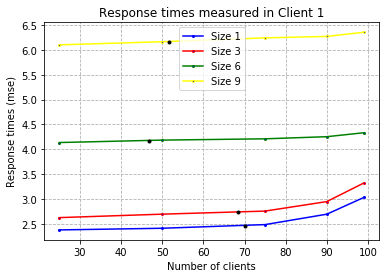

In [136]:
plot_percentils_for_Client(c1_percentils_avg, c1_percentils_std,1, percentile_of_avg_c1, c1_avg)

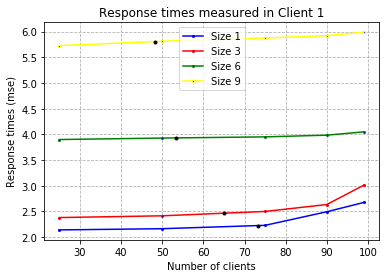

In [137]:
plot_percentils_for_Client(c2_percentils_avg, c2_percentils_std,1, percentile_of_avg_c2, c2_avg)

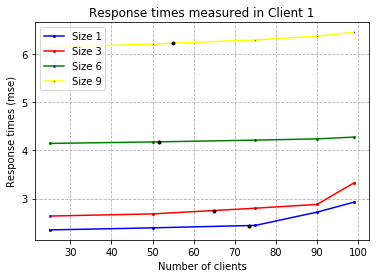

In [138]:
plot_percentils_for_Client(c3_percentils_avg, c3_percentils_std,1, percentile_of_avg_c3, c3_avg)

# AGGREGATE FOR ALL THE CLIENTS


In [139]:
def weigth_latencies(latencies_avg_c1, latencies_avg_c2, latencies_avg_c3,
                     latencies_std_c1, latencies_std_c2, latencies_std_c3
                     , th1, th2, th3):
    weigthed_latencies_avg = np.zeros(60)
    weigthed_latencies_std = np.zeros(60)
    w1 = th1/(th1+th2+th3)
    w2 = th2/(th1+th2+th3)
    w3 = th3/(th1+th2+th3)
    for i in range(0,60,1):
        weigthed_latencies_avg[i] = latencies_avg_c1[i]*w1 + latencies_avg_c2[i]*w2 +latencies_avg_c3[i]*w3
        weigthed_latencies_std[i] = latencies_std_c1[i]*w1 + latencies_std_c2[i]*w2 +latencies_std_c3[i]*w3
        
    return weigthed_latencies_avg, weigthed_latencies_std    




In [140]:
latencies_avg_s1, latencies_std_s1 = weigth_latencies(c1_all_avg[0], c2_all_avg[0], c3_all_avg[0],
                                                      c1_all_std[0], c2_all_std[0], c3_all_std[0],
                                                        c1_throughput[0], c2_throughput[0], c3_throughput[0])

latencies_avg_s3, latencies_std_s3 = weigth_latencies(c1_all_avg[1], c2_all_avg[1], c3_all_avg[1],
                                                      c1_all_std[1], c2_all_std[1], c3_all_std[1],
                                                        c1_throughput[1], c2_throughput[1], c3_throughput[1])

latencies_avg_s6, latencies_std_s6 = weigth_latencies(c1_all_avg[2], c2_all_avg[2], c3_all_avg[2],
                                                      c1_all_std[2], c2_all_std[2], c3_all_std[2],
                                                        c1_throughput[2], c2_throughput[2], c3_throughput[2])

latencies_avg_s9, latencies_std_s9 = weigth_latencies(c1_all_avg[3], c2_all_avg[3], c3_all_avg[3],
                                                      c1_all_std[3], c2_all_std[3], c3_all_std[3],
                                                        c1_throughput[3], c2_throughput[3], c3_throughput[3])

latencies_avg = [latencies_avg_s1, latencies_avg_s3, latencies_avg_s6, latencies_avg_s9]
latencies_std = [latencies_std_s1, latencies_std_s3, latencies_std_s6, latencies_std_s9]

allC_avg = np.zeros(4)
allC_std = np.zeros(4)

for i in range(0,4,1):
    allC_avg[i] = np.mean( latencies_avg[i])
    allC_std[i] = np.mean( latencies_std[i])

    
percentile_of_avg_allC = np.zeros(4)

for i in range(0,4,1):
    percentile_of_avg_allC[i] = scipy.stats.percentileofscore(latencies_avg[i], allC_avg[i])

    

allC_percentils_avg = np.zeros((4,5))
allC_percentils_std = np.zeros((4,5))

percentils = [25, 50, 75, 90, 99 ]
for count in range(0,4,1): #for each key size
    for i in range(0,5,1): #for each percentile
        allC_percentils_avg[count][i] = np.percentile(latencies_avg[count], percentils[i])

        allC_percentils_std[count][i] = np.percentile(latencies_std[count], percentils[i])


In [141]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
def plot_percentils_for_allClients(allC_percentils_avg, percentile_of_avg_allC, allC_avg ):
#USE clients
    fig, ax_lst = plt.subplots(1, 1) 
    plt.xlabel('Number of clients')
    plt.ylabel('Response times (mse)')
    plt.title("Response times measured in Client ")
    plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
    line_1S, = plt.plot(percentils, allC_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_3S, = plt.plot(percentils, allC_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_6S, = plt.plot(percentils, allC_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
    line_9S, = plt.plot(percentils, allC_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

    plt.plot([percentile_of_avg_allC[0], percentile_of_avg_allC[1], percentile_of_avg_allC[2]-2,percentile_of_avg_allC[3] ],
         [allC_avg[0], allC_avg[1], allC_avg[2], allC_avg[3]],'o', color='black', markersize=5)
    #ax_lst.errorbar(percentils,allC_percentils_avg[0], yerr=c_percentils_std[0], fmt=None, ecolor='blue', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,allC_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,allC_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
    #ax_lst.errorbar(percentils,allC_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

    plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
    plt.savefig("PercentilsE52ROallSizes.png", bbox_inches='tight')

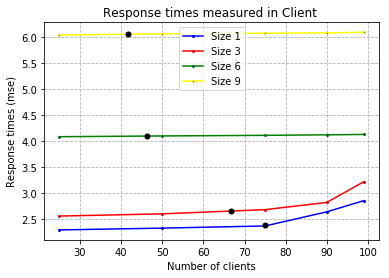

In [142]:
plot_percentils_for_allClients(allC_percentils_avg, percentile_of_avg_allC, allC_avg)

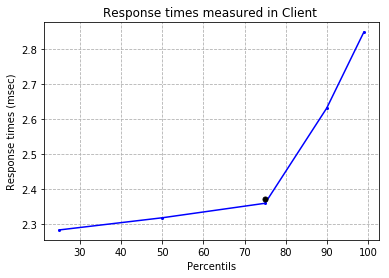

In [143]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
#USE clients
fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Percentils')
plt.ylabel('Response times (msec)')
plt.title("Response times measured in Client ")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
line_1S, = plt.plot(percentils, allC_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_3S, = plt.plot(percentils, allC_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_6S, = plt.plot(percentils, allC_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_9S, = plt.plot(percentils, allC_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

plt.plot([percentile_of_avg_allC[0],], [ allC_avg[0] ],'o', color='black', markersize=5)
#ax_lst.errorbar(percentils,allC_percentils_avg[0], yerr=c_percentils_std[0], fmt=None, ecolor='blue', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("PercentilsE52ROONLYSIZE1.png", bbox_inches='tight')

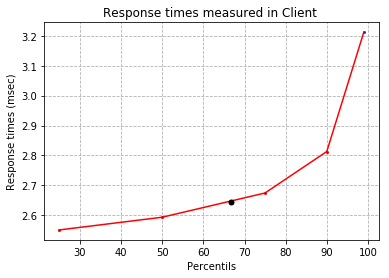

In [144]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
#USE clients
fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Percentils')
plt.ylabel('Response times (msec)')
plt.title("Response times measured in Client ")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
#line_1S, = plt.plot(percentils, allC_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
line_3S, = plt.plot(percentils, allC_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_6S, = plt.plot(percentils, allC_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_9S, = plt.plot(percentils, allC_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

plt.plot([scipy.stats.percentileofscore(latencies_avg[1], np.mean(latencies_avg[1]))], [ np.mean(latencies_avg[1]) ],'o', color='black', markersize=5)

#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("PercentilsE52ROONLYSIZE3.png", bbox_inches='tight')

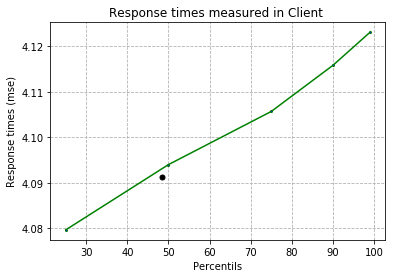

In [145]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
#USE clients
fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Percentils')
plt.ylabel('Response times (mse)')
plt.title("Response times measured in Client ")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
#line_1S, = plt.plot(percentils, allC_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_3S, = plt.plot(percentils, allC_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
line_6S, = plt.plot(percentils, allC_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_9S, = plt.plot(percentils, allC_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

plt.plot([percentile_of_avg_allC[2],], [ allC_avg[2] ],'o', color='black', markersize=5)
#ax_lst.errorbar(percentils,allC_percentils_avg[0], yerr=c_percentils_std[0], fmt=None, ecolor='blue', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("PercentilsE52ROONLYSIZE6.png", bbox_inches='tight')

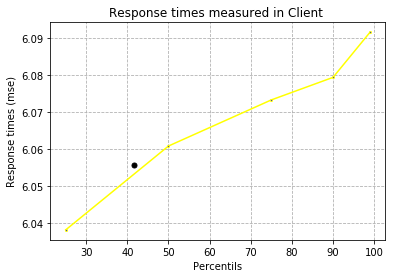

In [146]:
sizes = [1, 3, 6, 9]
percentils = [25, 50, 75, 90, 99 ]
#USE clients
fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Percentils')
plt.ylabel('Response times (mse)')
plt.title("Response times measured in Client ")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
#line_1S, = plt.plot(percentils, allC_percentils_avg[0], color='blue', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_3S, = plt.plot(percentils, allC_percentils_avg[1], color='red', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
#line_6S, = plt.plot(percentils, allC_percentils_avg[2], color='green', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)
line_9S, = plt.plot(percentils, allC_percentils_avg[3], color='yellow', linestyle='solid', marker='o',markerfacecolor='blue', markersize=2)

plt.plot([percentile_of_avg_allC[3]], [ allC_avg[3] ],'o', color='black', markersize=5)
#ax_lst.errorbar(percentils,allC_percentils_avg[0], yerr=c_percentils_std[0], fmt=None, ecolor='blue', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,allC_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("PercentilsE52ROONLYSIZE9.png", bbox_inches='tight')

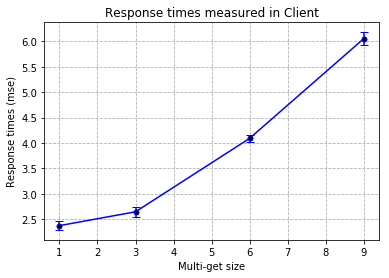

In [147]:
sizes = [1, 3, 6, 9]
avg_latencies = [np.mean(latencies_avg_s1), np.mean(latencies_avg_s3), np.mean(latencies_avg_s6), np.mean(latencies_avg_s9)]

fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Multi-get size')
plt.ylabel('Response times (mse)')
plt.title("Response times measured in Client")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
line_1S, = plt.plot(sizes, allC_avg, color='blue', linestyle='solid', marker='o',markerfacecolor='black', markersize=5)

#plt.plot([percentile_of_avg[0], percentile_of_avg[1], percentile_of_avg[2],percentile_of_avg[3] ],
 #    [c_avg[0], c_avg[1], c_avg[2], c_avg[3]],'o', color='black', markersize=3)
ax_lst.errorbar(sizes,allC_avg, yerr=allC_std, fmt=None, ecolor='blue', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)
allC_avg
allC_std
#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("LatenciesForAllSizesE52.png", bbox_inches='tight')

# HISTOGRAMS for the Client

In [148]:
print(np.min(latencies_avg_s6))
print(np.max(latencies_avg_s6))
print(np.mean(latencies_avg_s6))



4.045813227648825
4.124236266200483
4.091312637101548


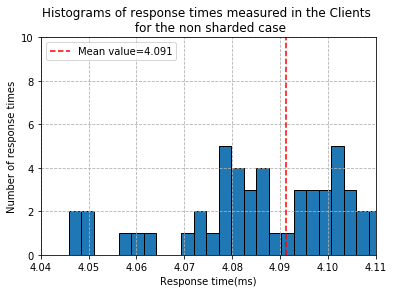

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path


fig, ax = plt.subplots(1, 1) 
n, bins =  np.histogram(latencies_avg_s6,30)
# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n

plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')


plt.xlabel('Response time(ms)')
plt.ylabel('Number of response times')
plt.title('Histograms of response times measured in the Clients \n for the non sharded case')
# we need a (numrects x numsides x 2) numpy array for the path helper
# function to build a compound path
XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

# get the Path object
barpath = path.Path.make_compound_path_from_polys(XY)
# make a patch out of it
patch = patches.PathPatch(barpath)
ax.add_patch(patch)
meanline = plt.axvline(x=np.mean(latencies_avg_s6), color='red',linestyle='dashed')

plt.legend([meanline],['Mean value='+str(np.round(np.mean(latencies_avg_s6),3))])

# update the view limits
ax.set_xlim(4.04 , 4.11)
ax.set_ylim(bottom.min(), 10)

plt.savefig("E52HistoAllClients_size6.png", bbox_inches='tight')
plt.show()

# HISTOGRAMS for the Middleware

In [150]:
file_path_m1 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Middleware1/64_threads/E52ROMidd1_T64_C2_try' #1_Size6.log'
file_path_m2 = '/home/fla/Desktop/asl-fall18-project/Experiments/Exp_5/5.2/R_only/Middleware2/64_threads/E52ROMidd2_T64_C2_try'

In [151]:

def extract_latencies_from_middleware(file_path):
    service_time = np.zeros(55)
    waiting_time = np.zeros(55)
    parsing_time = np.zeros(55)
    tot_time = np.zeros(55)
    
    with open(file_path) as file_client:
        file_client=file_client.readlines()
        for i in range(0,len(file_client),1):
            if(file_client[i][0:10]=='Aggregated'):
                line = file_client[i]
                #print(line)
                count=0
                for j in range(i+2+1, i+2+55+1,1):
                    waiting_time[count] = float(str(file_client[j]).split()[2])
                    service_time[count] = float(str(file_client[j]).split()[3])
                    parsing_time[count] = float(str(file_client[j]).split()[4])
                    count+=1
                    #print("Waiting_time: "+str(float(str(file_client[j]).split()[2])))
                    #print("Service_time: "+str(float(str(file_client[j]).split()[3])))
                    #print("Parsing_time: "+str(float(str(file_client[j]).split()[4])))
                
            if(file_client[i][0:20]=='Throughput(ops/sec):'):
                throughput = str(file_client[i]).split()
                throughput = float(throughput[1][5:(len(throughput[1])-1)])

            if(file_client[i][0:12]=='QueueLength:'):
                #print(file_client[i].split())
                queue_length = str(file_client[i]).split()
                queue_length = float(queue_length[1][5:(len(queue_length[1])-1)])
            
        
    for i in range(0,55,1):
        tot_time[i] = waiting_time[i]+service_time[i]+parsing_time[i]
    return tot_time, waiting_time, service_time, throughput , queue_length #60 valori di response time e il throughput

In [152]:
def weigth_aggregates_for_tries(file_path, Size):
    path_1 = file_path+str(1)+'_Size'+str(Size)+'.log'
    path_2 = file_path+str(2)+'_Size'+str(Size)+'.log'
    path_3 = file_path+str(3)+'_Size'+str(Size)+'.log'
    
    latencies_1, waiting_time_1, service_time1, th1, queue_l1 = extract_latencies_from_middleware(path_1)
    latencies_2, waiting_time_2, service_time2, th2, queue_l2 = extract_latencies_from_middleware(path_2)
    latencies_3, waiting_time_3, service_time3, th3, queue_l3 = extract_latencies_from_middleware(path_3)
    
    weigthed_latencies = np.zeros(len(latencies_3))
    weigthed_waiting_time = np.zeros(len(latencies_3))
    weigthed_service_time = np.zeros(len(latencies_3))
    
    tot_throughput = (th1+th2+th3)
    w1 = th1/tot_throughput
    w2 = th2/tot_throughput
    w3 = th3/tot_throughput

    queue_length_avg = np.average([queue_l1, queue_l2, queue_l3], axis=0, weights=[w1, w2, w3])
    queue_length_std = np.std([queue_l1, queue_l2, queue_l3])

    for i in range(0,len(latencies_3),1):
        weigthed_latencies[i] = latencies_1[i]*w1+latencies_2[i]*w2+latencies_3[i]*w3
        weigthed_waiting_time[i] = waiting_time_1[i]*w1+waiting_time_2[i]*w2+waiting_time_3[i]*w3
        weigthed_service_time[i] = service_time1[i]*w1+service_time2[i]*w2+service_time3[i]*w3
        
    return weigthed_latencies, weigthed_waiting_time, weigthed_service_time, np.mean([th1, th2, th3]), queue_length_avg, queue_length_std

In [153]:
def weigth_aggregates_for_middlewares(latencies_m1, latencies_m2, throughput_m1, throughput_m2):

    weigthed_latencies = np.zeros(len(latencies_m1))
    tot_throughput = (throughput_m1+throughput_m2)
    
    w1 = throughput_m1/tot_throughput
    w2 = throughput_m2/tot_throughput
    
    for i in range(0,len(latencies_m1),1):
        weigthed_latencies[i] = latencies_m1[i]*w1+latencies_m2[i]*w2
        
    return weigthed_latencies



In [154]:
latencies_m1, waiting_time_m1, service_time_m1,  throughput_m1, queue_length_avg_m1, queue_length_std_m1 = weigth_aggregates_for_tries(file_path_m1, 6)
latencies_m2, waiting_time_m2, service_time_m2,throughput_m2,  queue_length_avg_m2, queue_length_std_m2 = weigth_aggregates_for_tries(file_path_m2, 6)
weigthed_latencies = weigth_aggregates_for_middlewares(latencies_m1,latencies_m2, throughput_m1, throughput_m2)
weigthed_waiting_time = weigth_aggregates_for_middlewares(waiting_time_m1,waiting_time_m2, throughput_m1, throughput_m2)
weigthed_service_time = weigth_aggregates_for_middlewares(service_time_m1,service_time_m2, throughput_m1, throughput_m2)
queue_length = queue_length_avg_m1 + queue_length_avg_m2

In [155]:
weigthed_latencies

array([2.7797434 , 2.976839  , 2.97283794, 2.76047572, 3.01230526,
       2.96801522, 2.96277063, 3.02004271, 2.95032811, 2.89358184,
       2.89088745, 2.89658076, 2.92094494, 2.99732273, 2.94939218,
       3.04979907, 3.04800226, 3.05370606, 3.06977739, 3.08486243,
       3.04643803, 3.02741485, 3.05021758, 3.06253408, 3.08619504,
       3.02325845, 3.07282717, 3.06071709, 3.03621232, 3.05275064,
       3.00777281, 2.9198253 , 3.03156658, 3.00856879, 3.06096837,
       3.05371552, 3.04761118, 3.06087443, 3.06577   , 3.09480986,
       3.03302335, 3.08829857, 3.02736805, 3.0750108 , 3.05722163,
       3.03993257, 3.03920944, 3.03624484, 3.05381051, 3.02187072,
       3.02311294, 3.03942943, 3.08588512, 3.00942164, 3.01721816])

In [156]:
print("min: "+str(np.min(weigthed_latencies)))
print("max: "+str(np.max(weigthed_latencies)))
print("mean: "+str(np.mean(weigthed_latencies)))

min: 2.7604757183433435
max: 3.094809858145799
mean: 3.0140967443680635


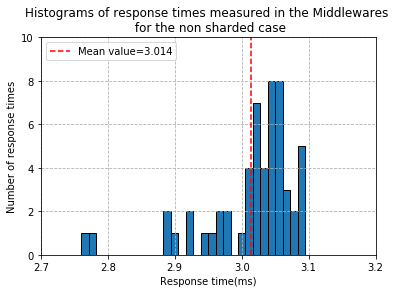

In [157]:

fig, ax = plt.subplots(1, 1) 
n, bins =  np.histogram(weigthed_latencies,30)
# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n

plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')


plt.xlabel('Response time(ms)')
plt.ylabel('Number of response times')
plt.title('Histograms of response times measured in the Middlewares \n for the non sharded case')
# we need a (numrects x numsides x 2) numpy array for the path helper
# function to build a compound path
XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

# get the Path object
barpath = path.Path.make_compound_path_from_polys(XY)
# make a patch out of it
patch = patches.PathPatch(barpath)
ax.add_patch(patch)
meanline = plt.axvline(x=np.mean(weigthed_latencies), color='red',linestyle='dashed')

plt.legend([meanline],['Mean value='+str(np.round(np.mean(weigthed_latencies),3))])

# update the view limits
ax.set_xlim(2.7, 3.2)
ax.set_ylim(bottom.min(), 10)

plt.savefig("E52HistoAllMiddlewares_size6.png", bbox_inches='tight')
plt.show()

In [158]:
weigthed_latencies = np.zeros((4,55))
weigthed_waiting_time = np.zeros((4,55))
weigthed_service_time = np.zeros((4,55))
queue_length = np.zeros(4) 
throughput = np.zeros(4)


sizes = [1, 3, 6, 9]
for i in range(0,len(sizes),1):
    latencies_m1, waiting_time_m1, service_time_m1,  throughput_m1, queue_length_avg_m1, queue_length_std_m1 = weigth_aggregates_for_tries(file_path_m1, sizes[i])
    latencies_m2, waiting_time_m2, service_time_m2 ,throughput_m2,  queue_length_avg_m2, queue_length_std_m2 = weigth_aggregates_for_tries(file_path_m2, sizes[i])
    weigthed_latencies[i] = weigth_aggregates_for_middlewares(latencies_m1,latencies_m2, throughput_m1, throughput_m2)
    weigthed_waiting_time[i] = weigth_aggregates_for_middlewares(waiting_time_m1,waiting_time_m2, throughput_m1, throughput_m2)
    weigthed_service_time[i] = weigth_aggregates_for_middlewares(service_time_m1,service_time_m2, throughput_m1, throughput_m2)
    queue_length[i] = queue_length_avg_m1 + queue_length_avg_m2
    #print("Key size: "+str(sizes[i])+"th1: "+str(throughput_m1)+"th2: "+str(throughput_m2))
    throughput[i] = throughput_m1 + throughput_m2

In [159]:
allC_avg
clients = 2*2*3 #2 clients per each instance, per each clients machine

print("key-size-1: mean: "+str(allC_avg[0])+" -- std: "+str(allC_std[0]))
print("key-size-3: mean: "+str(allC_avg[1])+" -- std: "+str(allC_std[1]))
print("key-size-6: mean: "+str(allC_avg[2])+" -- std: "+str(allC_std[2]))
print("key-size-9: mean: "+str(allC_avg[3])+" -- std: "+str(allC_std[3]))

print("key-size-1: interactive_law_mean: "+str(clients/(allC_avg[0]/1000))+" -- interactive_law_std: "+str(clients/(allC_std[0]/1000)))
print("key-size-3: interactive_law_mean: "+str(clients/(allC_avg[1]/1000))+" -- interactive_law_std: "+str(clients/(allC_std[1]/1000)))
print("key-size-6: interactive_law_mean: "+str(clients/(allC_avg[2]/1000))+" -- interactive_law_std: "+str(clients/(allC_std[2]/1000)))
print("key-size-9: interactive_law_mean: "+str(clients/(allC_avg[3]/1000))+" -- interactive_law_std: "+str(clients/(allC_std[3]/1000)))

#print("key-size-1: mean: "+str(np.mean(throughput[0]))+" -- std: "+str(np.std(throughput[0])))
#print("key-size-3: mean: "+str(np.mean(throughput[1]))+" -- std: "+str(np.std(throughput[1])))
#print("key-size-6: mean: "+str(np.mean(throughput[2]))+" -- std: "+str(np.std(throughput[2])))
#print("key-size-9: mean: "+str(np.mean(throughput[3]))+" -- std: "+str(np.std(throughput[3])))


key-size-1: mean: 2.3713594884506453 -- std: 0.08416811484722167
key-size-3: mean: 2.6444310911509477 -- std: 0.09762917587632312
key-size-6: mean: 4.091312637101548 -- std: 0.07247252133029734
key-size-9: mean: 6.055553329075792 -- std: 0.1260750274342736
key-size-1: interactive_law_mean: 5060.388379933207 -- interactive_law_std: 142571.8043202213
key-size-3: interactive_law_mean: 4537.83804015751 -- interactive_law_std: 122914.0765789279
key-size-6: interactive_law_mean: 2933.0440043079398 -- interactive_law_std: 165579.99887032172
key-size-9: interactive_law_mean: 1981.652104751831 -- interactive_law_std: 95181.41890753055


In [160]:
print("Parsing time")
print("key-size-1: mean: "+str(np.mean(weigthed_latencies[0])-np.mean(weigthed_service_time[0])-np.mean(weigthed_waiting_time[0])))
print("key-size-3: mean: "+str(np.mean(weigthed_latencies[1])-np.mean(weigthed_service_time[1])-np.mean(weigthed_waiting_time[1])))
print("key-size-6: mean: "+str(np.mean(weigthed_latencies[2])-np.mean(weigthed_service_time[2])-np.mean(weigthed_waiting_time[2])))
print("key-size-9: mean: "+str(np.mean(weigthed_latencies[3])-np.mean(weigthed_service_time[3])-np.mean(weigthed_waiting_time[3])))


Parsing time
key-size-1: mean: 0.21750708586524967
key-size-3: mean: 0.4170035980143093
key-size-6: mean: 1.2655529967973997
key-size-9: mean: 1.1117592040003286


In [161]:
print("key-size-1: mean: "+str(np.mean(weigthed_service_time[0]))+" -- std: "+str(np.std(weigthed_service_time[0])))
print("key-size-3: mean: "+str(np.mean(weigthed_service_time[1]))+" -- std: "+str(np.std(weigthed_service_time[1])))
print("key-size-6: mean: "+str(np.mean(weigthed_service_time[2]))+" -- std: "+str(np.std(weigthed_service_time[2])))
print("key-size-9: mean: "+str(np.mean(weigthed_service_time[3]))+" -- std: "+str(np.std(weigthed_service_time[3])))


key-size-1: mean: 1.1285869488440174 -- std: 0.08400612106826777
key-size-3: mean: 1.1601792962727548 -- std: 0.0912287512776398
key-size-6: mean: 1.6732805801392276 -- std: 0.06772212789269745
key-size-9: mean: 3.759107175170486 -- std: 0.2597463594000057


In [162]:
print("key-size-1: mean: "+str(np.mean(weigthed_waiting_time[0]))+" -- std: "+str(np.std(weigthed_waiting_time[0])))
print("key-size-3: mean: "+str(np.mean(weigthed_waiting_time[1]))+" -- std: "+str(np.std(weigthed_waiting_time[1])))
print("key-size-6: mean: "+str(np.mean(weigthed_waiting_time[2]))+" -- std: "+str(np.std(weigthed_waiting_time[2])))
print("key-size-9: mean: "+str(np.mean(weigthed_waiting_time[3]))+" -- std: "+str(np.std(weigthed_waiting_time[3])))


key-size-1: mean: 0.07609563009607936 -- std: 0.007061678450765418
key-size-3: mean: 0.07532839913035647 -- std: 0.006883723991282897
key-size-6: mean: 0.07526316743143614 -- std: 0.00717941871284459
key-size-9: mean: 0.07493392226529107 -- std: 0.00688208482789703


In [163]:
print("key-size-1: mean: "+str(np.mean(weigthed_latencies[0]))+" -- std: "+str(np.std(weigthed_latencies[0])))
print("key-size-3: mean: "+str(np.mean(weigthed_latencies[1]))+" -- std: "+str(np.std(weigthed_latencies[1])))
print("key-size-6: mean: "+str(np.mean(weigthed_latencies[2]))+" -- std: "+str(np.std(weigthed_latencies[2])))
print("key-size-9: mean: "+str(np.mean(weigthed_latencies[3]))+" -- std: "+str(np.std(weigthed_latencies[3])))


key-size-1: mean: 1.4221896648053465 -- std: 0.10392344311622587
key-size-3: mean: 1.6525112934174206 -- std: 0.10087530888815002
key-size-6: mean: 3.0140967443680635 -- std: 0.06930724848804944
key-size-9: mean: 4.945800301436106 -- std: 0.07144740683045271


In [164]:
clients = 128

print("key-size-1: interactive_law_mean: "+str(clients/ (np.mean(weigthed_service_time[0])/1000))+" -- interactive_law_std: "+str(clients/ (np.std(weigthed_service_time[0])/1000)))
print("key-size-1: interactive_law_mean: "+str(clients/ (np.mean(weigthed_service_time[1])/1000))+" -- interactive_law_std: "+str(clients/ (np.std(weigthed_service_time[1])/1000)))
print("key-size-1: interactive_law_mean: "+str(clients/ (np.mean(weigthed_service_time[2])/1000))+" -- interactive_law_std: "+str(clients/ (np.std(weigthed_service_time[2])/1000)))
print("key-size-1: interactive_law_mean: "+str(clients/ (np.mean(weigthed_service_time[3])/1000))+" -- interactive_law_std: "+str(clients/ (np.std(weigthed_service_time[3])/1000)))


key-size-1: interactive_law_mean: 113416.16180402148 -- interactive_law_std: 1523698.4921132177
key-size-1: interactive_law_mean: 110327.77469070397 -- interactive_law_std: 1403066.4478838795
key-size-1: interactive_law_mean: 76496.43551671984 -- interactive_law_std: 1890076.4636753593
key-size-1: interactive_law_mean: 34050.63863181684 -- interactive_law_std: 492788.427509322


In [165]:
print("key-size-1: mean: "+str(np.mean(throughput[0]))+" -- std: "+str(np.std(throughput[0])))
print("key-size-3: mean: "+str(np.mean(throughput[1]))+" -- std: "+str(np.std(throughput[1])))
print("key-size-6: mean: "+str(np.mean(throughput[2]))+" -- std: "+str(np.std(throughput[2])))
print("key-size-9: mean: "+str(np.mean(throughput[3]))+" -- std: "+str(np.std(throughput[3])))


key-size-1: mean: 4959.0633333333335 -- std: 0.0
key-size-3: mean: 4451.423333333334 -- std: 0.0
key-size-6: mean: 2865.8533333333335 -- std: 0.0
key-size-9: mean: 1940.75 -- std: 0.0


In [166]:
print("key-size-1: mean: "+str(np.mean(queue_length[0]))+" -- std: "+str(np.std(queue_length[0])))
print("key-size-3: mean: "+str(np.mean(queue_length[1]))+" -- std: "+str(np.std(queue_length[1])))
print("key-size-6: mean: "+str(np.mean(queue_length[2]))+" -- std: "+str(np.std(queue_length[2])))
print("key-size-9: mean: "+str(np.mean(queue_length[3]))+" -- std: "+str(np.std(queue_length[3])))


key-size-1: mean: 0.44107448257642834 -- std: 0.0
key-size-3: mean: 0.4379193469051586 -- std: 0.0
key-size-6: mean: 0.1434135883570798 -- std: 0.0
key-size-9: mean: 0.14310757863460455 -- std: 0.0


In [168]:
print(str(np.mean(throughput[0]))+("--> Actual requests: ")+(str(np.mean(throughput[0]))))


print(str(np.mean(throughput[1]))+("--> Actual gets: ")+
      (str((np.mean(throughput[1])/2)*3)))

print(str(np.mean(throughput[2]))+("--> Actual requests: ")+
      (str((np.mean(throughput[2])/2)*6)))

print(str(np.mean(throughput[3]))+("--> Actual requests: ")+
      (str((np.mean(throughput[3])/2)*9)))



4959.0633333333335--> Actual requests: 4959.0633333333335
4451.423333333334--> Actual gets: 6677.135000000001
2865.8533333333335--> Actual requests: 8597.560000000001
1940.75--> Actual requests: 8733.375


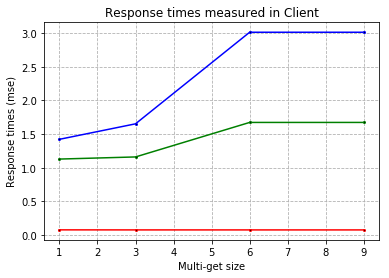

In [126]:
sizes = [1, 3, 6, 9]

fig, ax_lst = plt.subplots(1, 1) 
plt.xlabel('Multi-get size')
plt.ylabel('Response times (mse)')
plt.title("Response times measured in Client")
plt.grid('true', axis='both', fillstyle='left', linestyle='dashed',clip_on='true')
line_latency, = plt.plot(sizes, np.mean([weigthed_latencies[0], weigthed_latencies[1], weigthed_latencies[2],
                                         weigthed_latencies[2]], axis=1) , color='blue', linestyle='solid', marker='o',markerfacecolor='black', markersize=2)

line_waiting_time, = plt.plot(sizes, np.mean([weigthed_waiting_time[0], weigthed_waiting_time[1], weigthed_waiting_time[2],
                                         weigthed_waiting_time[2]], axis=1) , color='red', linestyle='solid', marker='o',markerfacecolor='black', markersize=2)
line_service_time, = plt.plot(sizes, np.mean([weigthed_service_time[0], weigthed_service_time[1], weigthed_service_time[2],
                                         weigthed_service_time[2]], axis=1) , color='green', linestyle='solid', marker='o',markerfacecolor='black', markersize=2)


#plt.plot([percentile_of_avg[0], percentile_of_avg[1], percentile_of_avg[2],percentile_of_avg[3] ],
 #    [c_avg[0], c_avg[1], c_avg[2], c_avg[3]],'o', color='black', markersize=3)
#ax_lst.errorbar(sizes,allC_avg, yerr=allC_std, fmt=None, ecolor='blue', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[1], yerr=c_percentils_std[1], fmt=None, ecolor='red', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[2], yerr=c_percentils_std[2], fmt=None, ecolor='green', capthick=1, capsize=4)
#ax_lst.errorbar(percentils,c_percentils_avg[3], yerr=c_percentils_std[3], fmt=None, ecolor='yellow', capthick=1, capsize=4)

#plt.legend([ line_1S, line_3S, line_6S, line_9S ], ['Size 1','Size 3', 'Size 6', 'Size 9'])
plt.savefig("E52LatencyWaitingTimeAndServiceTime.png", bbox_inches='tight')